<a href="https://colab.research.google.com/github/somilasthana/MachineLearningSkills/blob/master/Application_NLP_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import sklearn.feature_extraction.text as text
from glob import glob
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Uncomment for the first time
#!wget https://liferay.de.dariah.eu/tatom/_downloads/datasets.zip
#!unzip /content/datasets.zip > /dev/null

--2019-06-28 00:22:31--  https://liferay.de.dariah.eu/tatom/_downloads/datasets.zip
Resolving liferay.de.dariah.eu (liferay.de.dariah.eu)... 134.76.30.131
Connecting to liferay.de.dariah.eu (liferay.de.dariah.eu)|134.76.30.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57659024 (55M) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>]  54.99M  19.4MB/s    in 2.8s    

2019-06-28 00:22:34 (19.4 MB/s) - ‘datasets.zip’ saved [57659024/57659024]



In [0]:
data_dir = "/content/data/french-tragedy/"
filenames_with_path = sorted(glob(data_dir +"/*.txt"))
filenames = np.array(sorted(os.listdir(data_dir)))

In [9]:
filenames_with_path[:4]

['/content/data/french-tragedy/Crebillon_TR-V-1703-Idomenee.txt',
 '/content/data/french-tragedy/Crebillon_TR-V-1707-Atree.txt',
 '/content/data/french-tragedy/Crebillon_TR-V-1708-Electre.txt',
 '/content/data/french-tragedy/Crebillon_TR-V-1711-Rhadamisthe.txt']

In [0]:
vectorizer = text.CountVectorizer(input='filename')

In [0]:
dtm = vectorizer.fit_transform(filenames_with_path)

In [0]:
vocab = np.array(vectorizer.get_feature_names())

In [0]:
dtm = dtm.toarray()

In [14]:
dtm.shape

(59, 16607)

In [0]:
lengths = np.sum(dtm, axis=1)

Text(0.5, 1.0, 'Play length in words')

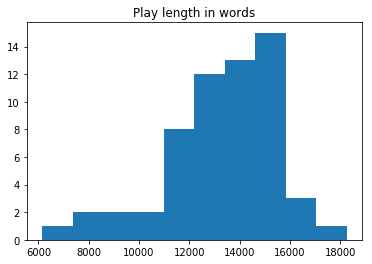

In [20]:
plt.hist(lengths)
plt.title("Play length in words")

In [22]:
max(lengths), filenames_with_path[np.argmax(lengths)]

(18253, '/content/data/french-tragedy/PCorneille_TR-V-1661-Toisondor.txt')

In [23]:
min(lengths), filenames_with_path[np.argmax(lengths)]

(6150, '/content/data/french-tragedy/PCorneille_TR-V-1661-Toisondor.txt')

## Plot and Visualize Documents

In [0]:
dist = 1 - cosine_similarity(dtm)

In [32]:
dist.shape

(59, 59)

In [0]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)

In [0]:
pos = mds.fit_transform(dist)

In [33]:
pos.shape

(59, 2)

In [0]:
names = []
authors = []
for fn in filenames:
  author = fn.split('_')[0]
  year = fn.split('-')[2]
  authors.append(author)
  names.append(author + year)

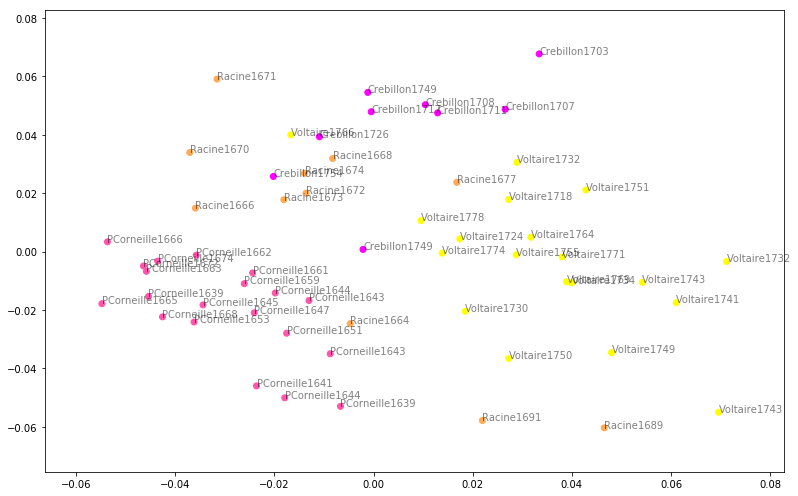

In [38]:
plt.figure(figsize=(11.3, 7))

xs, ys = pos[:, 0], pos[:, 1]
authors_unique = sorted(set(authors))

colors = [authors_unique.index(a) for a in authors]
plt.scatter(xs, ys, c=colors, cmap='spring')

for x, y, name in zip(xs, ys, names):
  plt.text(x, y, name, alpha=0.5, fontsize=10)
  
plt.tight_layout()

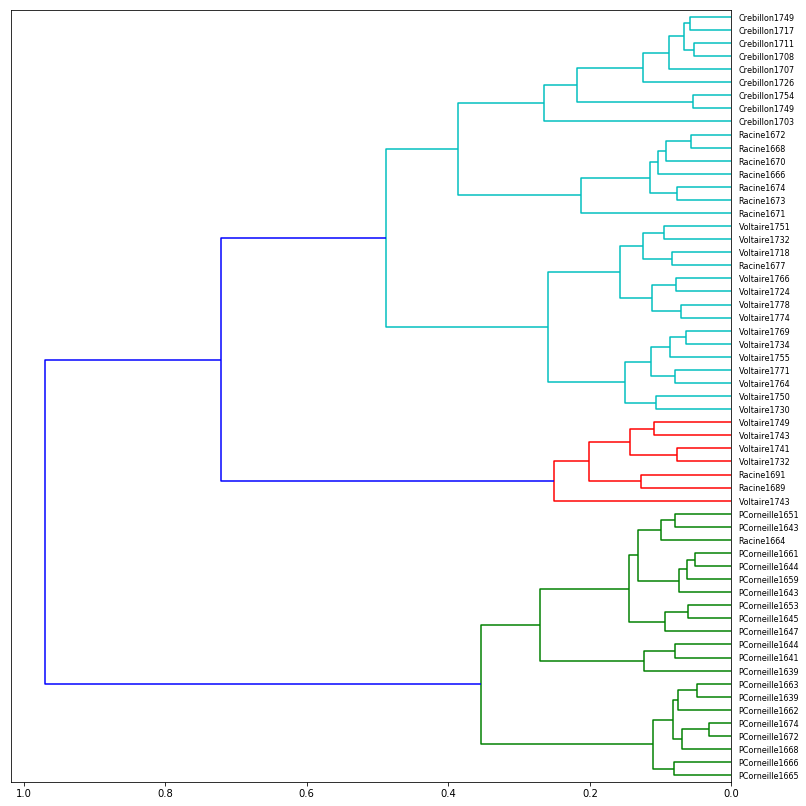

In [42]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)
plt.figure(figsize=(11.3, 11.3))

dendrogram(linkage_matrix, orientation="left", labels=names, leaf_font_size=8)
plt.tight_layout()

In [0]:
#Racine’s atypical plays

outliers = [1664, 1677, 1689, 1691]
racine_years = []
for fn in filenames:
  author = fn.split('_')[0]
  year = int(fn.split('-')[2])
  if author == "Racine":
    racine_years.append(year)

In [0]:
racine_years = np.array(racine_years)
colors = []

for year in racine_years:
  colors.append('orange' if year in outliers else 'cyan')


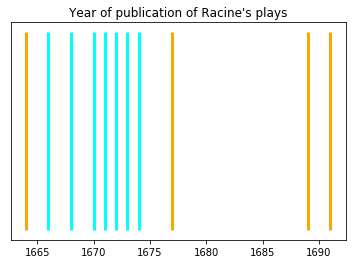

In [47]:
plt.vlines(racine_years, 0, 1, linewidth=3, color=colors)
plt.title("Year of publication of Racine's plays")
ax = plt.gca()
ax.yaxis.set_visible(False)

## Features

In [0]:
"""
A useful way to explore the atypical plays further is to directly compare the 
outliers with a fictitious “average” Racine tragedy. 
"""

In [0]:
vectorizer = text.TfidfVectorizer(input='filename', min_df=15)
dtm = vectorizer.fit_transform(filenames_with_path)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

## Modeling

In [0]:
from sklearn import decomposition
num_topics = 15

clf = decomposition.NMF(n_components=num_topics, random_state=42)

In [0]:
doctopic_chunks = clf.fit_transform(dtm)

In [0]:
doctopic_chunks += 1e-6

doctopic_chunks = doctopic_chunks / np.sum(doctopic_chunks, axis=1, keepdims=True)

In [14]:
doctopic_chunks[0, :]

array([8.05980685e-02, 9.94454840e-07, 7.31903582e-02, 2.97846891e-01,
       9.94454840e-07, 3.28706005e-02, 1.14489813e-01, 6.92289285e-02,
       2.77188152e-01, 9.94454840e-07, 9.94454840e-07, 9.94454840e-07,
       4.13506607e-02, 1.24401372e-02, 7.91417376e-04])

In [0]:
play_names_chunks = []
for fn in filenames:
  play_names_chunks.append(fn.split(".")[0])

In [61]:
play_names_chunks[:4]

['Crebillon_TR-V-1703-Idomenee',
 'Crebillon_TR-V-1707-Atree',
 'Crebillon_TR-V-1708-Electre',
 'Crebillon_TR-V-1711-Rhadamisthe']

In [62]:
num_plays = len(set(play_names_chunks))
num_plays

59

In [0]:
"""
import itertools
import operator
doctopic = np.zeros((num_plays, num_topics))
play_row_pairs = zip(play_names_chunks, doctopic_chunks)
play_names = []
for i, (name, pairs) in enumerate(itertools.groupby(play_row_pairs, key=operator.itemgetter(0))):
  rows = [row for _, row in pairs]
  doctopic[i, :] = sum(rows) / len(rows)
  play_names.append(name)
"""
doctopic  = doctopic_chunks


## Analysis on Racine

In [0]:
# Analysis on Racine

racine_plays = [name for name in play_names_chunks if name.startswith('Racine')]
racine_atypical = ['Racine_TR-V-1664-Thebaide', 'Racine_TR-V-1677-Phedre', 'Racine_TR-V-1689-Esther', 'Racine_TR-V-1691-Athalie']
racine_normal = list( set(racine_plays) - set(racine_atypical))

In [0]:
doctopic_racine_normal = np.mean(doctopic[np.in1d(play_names_chunks, racine_normal)], axis=0)

In [0]:
doctopic_racine_atypical = doctopic[np.in1d(play_names_chunks, racine_atypical)]

In [69]:
racine_atypical

['Racine_TR-V-1664-Thebaide',
 'Racine_TR-V-1677-Phedre',
 'Racine_TR-V-1689-Esther',
 'Racine_TR-V-1691-Athalie']

In [0]:
doctopic_of_interest = np.row_stack([doctopic_racine_normal, doctopic_racine_atypical])

In [73]:
doctopic_of_interest.shape[0]

5

In [0]:
play_names_of_interest = ['Racine-1666-1674-AVERAGE'] + racine_atypical

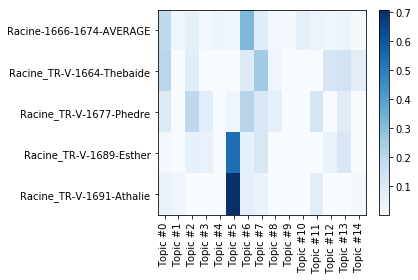

In [75]:
plt.pcolor(doctopic_of_interest, norm=None, cmap='Blues')
topic_labels = ['Topic #{}'.format(k) for k in range(num_topics)]

plt.xticks(np.arange(doctopic_of_interest.shape[1]) + 0.5,  topic_labels)
plt.yticks(np.arange(doctopic_of_interest.shape[0]) + 0.5, play_names_of_interest)

plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Blues')
plt.tight_layout()

## Topic Distribution

In [34]:
"""
We may as well come up with a systematic way of identifying topics that vary 
substantially across texts of interest. One way of doing this would be to 
calculate the standard deviation of the document-topic shares across the topics.
"""



array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [0]:
# Look at Topic - Word Distribution

topics_by_std = np.argsort(np.std(doctopic_of_interest, axis=0, ddof=1))[::-1]

In [79]:
topics_by_std[:5]

array([5, 6, 0, 7, 2])

In [0]:
num_top_words = 17
topic_words = []

In [0]:
for topic in clf.components_:
  word_idx = np.argsort(topic)[::-1][:num_top_words]
  topic_words.append(list(vocab[word_idx]))

In [90]:
for t in topics_by_std[:5]:
  print("Topic {0}, Words{1}".format(t, topic_words[t]))

Topic 5, Words['de', 'et', 'le', 'dieu', 'que', 'vous', 'la', 'les', 'un', 'ce', 'son', 'du', 'qui', 'des', 'il', 'est', 'qu']
Topic 6, Words['je', 'vous', 'de', 'que', 'ne', 'me', 'seigneur', 'la', 'il', 'madame', 'le', 'ce', 'ses', 'mes', 'plus', 'qu', 'une']
Topic 0, Words['vous', 'et', 'de', 'que', 'un', 'je', 'le', 'qui', 'qu', 'il', 'me', 'en', 'votre', 'ne', 'moi', 'pour', 'ma']
Topic 7, Words['le', 'il', 'et', 'de', 'est', 'la', 'son', 'un', 'fils', 'en', 'les', 'sa', 'qu', 'ce', 'que', 'je', 'on']
Topic 2, Words['et', 'de', 'que', 'un', 'je', 'en', 'la', 'tu', 'qu', 'le', 'mon', 'sa', 'ma', 'pour', 'me', 'son', 'les']


## Word Distribution

In [0]:
vectorizer = text.CountVectorizer(input='filename')
dtm = vectorizer.fit_transform(filenames_with_path)

In [0]:
dtm = dtm.toarray()

In [0]:
vocab = np.array(vectorizer.get_feature_names())
authors = np.array([fn.split('_')[0] for fn in filenames])

In [0]:
# convert to rates per 1000 words as this is easier to interpret
dtm = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [95]:
# These words appeared consistency
for word in ['et', 'un']:
  print("Rate per 1,000 words of {}".format(word))
  filenames_racine = filenames[authors == "Racine"]
  rates_racine = dtm[authors == "Racine", vocab == word ]
  for filename, rate in zip(filenames_racine, rates_racine):
    print("{:>40s}: {:.1f}".format(filename, rate))

Rate per 1,000 words of et
           Racine_TR-V-1664-Thebaide.txt: 32.8
          Racine_TR-V-1666-Alexandre.txt: 24.1
         Racine_TR-V-1668-Andromaque.txt: 22.8
        Racine_TR-V-1670-Britannicus.txt: 20.5
           Racine_TR-V-1671-Berenice.txt: 21.3
            Racine_TR-V-1672-Bajazet.txt: 24.9
         Racine_TR-V-1673-Mithridate.txt: 29.2
          Racine_TR-V-1674-Iphigenie.txt: 26.9
             Racine_TR-V-1677-Phedre.txt: 23.1
             Racine_TR-V-1689-Esther.txt: 24.6
            Racine_TR-V-1691-Athalie.txt: 25.7
Rate per 1,000 words of un
           Racine_TR-V-1664-Thebaide.txt: 13.2
          Racine_TR-V-1666-Alexandre.txt: 15.2
         Racine_TR-V-1668-Andromaque.txt: 13.7
        Racine_TR-V-1670-Britannicus.txt: 10.9
           Racine_TR-V-1671-Berenice.txt: 11.4
            Racine_TR-V-1672-Bajazet.txt: 12.2
         Racine_TR-V-1673-Mithridate.txt: 15.6
          Racine_TR-V-1674-Iphigenie.txt: 13.8
             Racine_TR-V-1677-Phedre.txt: 17.3
      

In [97]:
for word in ['je', 'me']:
  print("Rate per 1,000 words of {}".format(word))
  filenames_racine = filenames[authors == "Racine"]
  rates_racine = dtm[authors == "Racine", vocab == word ]
  for filename, rate in zip(filenames_racine, rates_racine):
    print("{:>40s}: {:.1f}".format(filename, rate))

Rate per 1,000 words of je
           Racine_TR-V-1664-Thebaide.txt: 19.6
          Racine_TR-V-1666-Alexandre.txt: 18.4
         Racine_TR-V-1668-Andromaque.txt: 28.8
        Racine_TR-V-1670-Britannicus.txt: 22.4
           Racine_TR-V-1671-Berenice.txt: 31.8
            Racine_TR-V-1672-Bajazet.txt: 25.8
         Racine_TR-V-1673-Mithridate.txt: 26.0
          Racine_TR-V-1674-Iphigenie.txt: 21.7
             Racine_TR-V-1677-Phedre.txt: 24.3
             Racine_TR-V-1689-Esther.txt: 11.1
            Racine_TR-V-1691-Athalie.txt: 12.6
Rate per 1,000 words of me
           Racine_TR-V-1664-Thebaide.txt: 7.0
          Racine_TR-V-1666-Alexandre.txt: 7.0
         Racine_TR-V-1668-Andromaque.txt: 9.6
        Racine_TR-V-1670-Britannicus.txt: 8.0
           Racine_TR-V-1671-Berenice.txt: 10.9
            Racine_TR-V-1672-Bajazet.txt: 8.8
         Racine_TR-V-1673-Mithridate.txt: 10.3
          Racine_TR-V-1674-Iphigenie.txt: 8.9
             Racine_TR-V-1677-Phedre.txt: 8.2
             